<a href="https://colab.research.google.com/github/DiogoBotton/FIAP_GS_Forest_Fires/blob/feature%2Fcnn/fire_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🚒 Classificador de Queimadas (CNN)
Projeto de classificação de imagens em duas categorias:

*   fire (queimada)
*   no_fire (não queimada)

Dataset utilizado [Wildfire Detection Image Data](https://www.kaggle.com/datasets/brsdincer/wildfire-detection-image-data/data)


Observação não utilizamos os dado do site [Satellite data to support disaster response worldwide](https://disasterscharter.org), pois não conseguimos acessar as imagens

# 1. Configuração inicial e montagem do drive

In [17]:
# Bibliotecas
import os
from pathlib import Path
import zipfile
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc
)

In [18]:
# Configurações Gerais
CONFIG = {
    "ZIP_PATH":       "/content/drive/MyDrive/Datasets/archive.zip",
    "EXTRACT_PATH":   "/content/dataset",
    "DATA_DIR":       "/content/dataset/archive",
    "BATCH_SIZE":     32,
    "IMAGE_SIZE":     (299, 299),
    "RANDOM_SEED":    42,
    "EXTENSIONS":     (".jpg", ".jpeg", ".png"),
    "LR_RAW":         1e-4,
    "LR_TL":          1e-4,
    "LR_FINE":        1e-6,
    "EPOCHS_RAW":     10,
    "EPOCHS_TL":      10,
    "EPOCHS_FINE":    50,
    "FINE_LAYERS":    10,
}

In [19]:
# Configuração Google Drive
# Cria diretórios

from google.colab import drive
drive.mount('/content/drive')

EXTRACT_PATH_obj = Path(CONFIG["EXTRACT_PATH"])
MODELS_PATH_obj = Path("/content/models")

EXTRACT_PATH_obj.mkdir(parents=True, exist_ok=True)
MODELS_PATH_obj.mkdir(parents=True, exist_ok=True)

# Extrai dados
DATA_ZIP_path = CONFIG["ZIP_PATH"]

# Add a check to see if the zip file exists
if not Path(DATA_ZIP_path).exists():
    print(f"❌ Erro: O arquivo ZIP não foi encontrado em {DATA_ZIP_path}")
    print("Por favor, verifique se o Google Drive está montado corretamente e se o caminho do arquivo ZIP está correto.")
else:
    with zipfile.ZipFile(DATA_ZIP_path, "r") as z:
        z.extractall(EXTRACT_PATH_obj)

    print(f"✅ Dados descompactados em {EXTRACT_PATH_obj}")
    !ls -l {EXTRACT_PATH_obj}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dados descompactados em /content/dataset
total 4
drwxr-xr-x 4 root root 4096 Jun  3 01:20 forest_fire


# 2. Pré- processamento

In [5]:
#  Exploração e contagem de imagens por pasta
from pathlib import Path


data_dir = Path(CONFIG["EXTRACT_PATH"]) / "forest_fire"
for subset in data_dir.iterdir():
    if subset.is_dir():
        for label in subset.iterdir():
            count = len(list(label.rglob("*.[jp][pn]g")))
            print(f"{subset.name:25s} | {label.name:8s} | {count:4d} imagens")

Training and Validation   | nofire   |  904 imagens
Training and Validation   | fire     |  928 imagens
Testing                   | nofire   |   46 imagens
Testing                   | fire     |   22 imagens


In [12]:
# Montar o DataFrame e split estratificado
import pandas as pd
from sklearn.model_selection import train_test_split

records = []
for subset in data_dir.iterdir():
    if subset.is_dir():
        for label in subset.iterdir():
            imgs = list(label.rglob("*.[jp][pn]g"))
            for img in imgs:
                records.append({
                    "filepath": str(img),
                    "label":    label.name,
                    "subset":   subset.name
                })

df = pd.DataFrame(records)
print(df.head())
print(df.groupby(["subset","label"]).size().unstack(fill_value=0))

# Split treino/validação e teste
train_val = df[df.subset=="Training and Validation"]
test     = df[df.subset=="Testing"]

train, val = train_test_split(
    train_val,
    test_size=0.2,
    stratify=train_val.label,
    # Change CFG["seed"] to CONFIG["RANDOM_SEED"]
    random_state=CONFIG["RANDOM_SEED"]
)

print(f"\n→ Treino: {len(train)}, Val: {len(val)}, Teste: {len(test)}")


                                            filepath   label  \
0  /content/dataset/forest_fire/Training and Vali...  nofire   
1  /content/dataset/forest_fire/Training and Vali...  nofire   
2  /content/dataset/forest_fire/Training and Vali...  nofire   
3  /content/dataset/forest_fire/Training and Vali...  nofire   
4  /content/dataset/forest_fire/Training and Vali...  nofire   

                    subset  
0  Training and Validation  
1  Training and Validation  
2  Training and Validation  
3  Training and Validation  
4  Training and Validation  
label                    fire  nofire
subset                               
Testing                    22      46
Training and Validation   928     904

→ Treino: 1465, Val: 367, Teste: 68


Visualizando amostras do dataset:


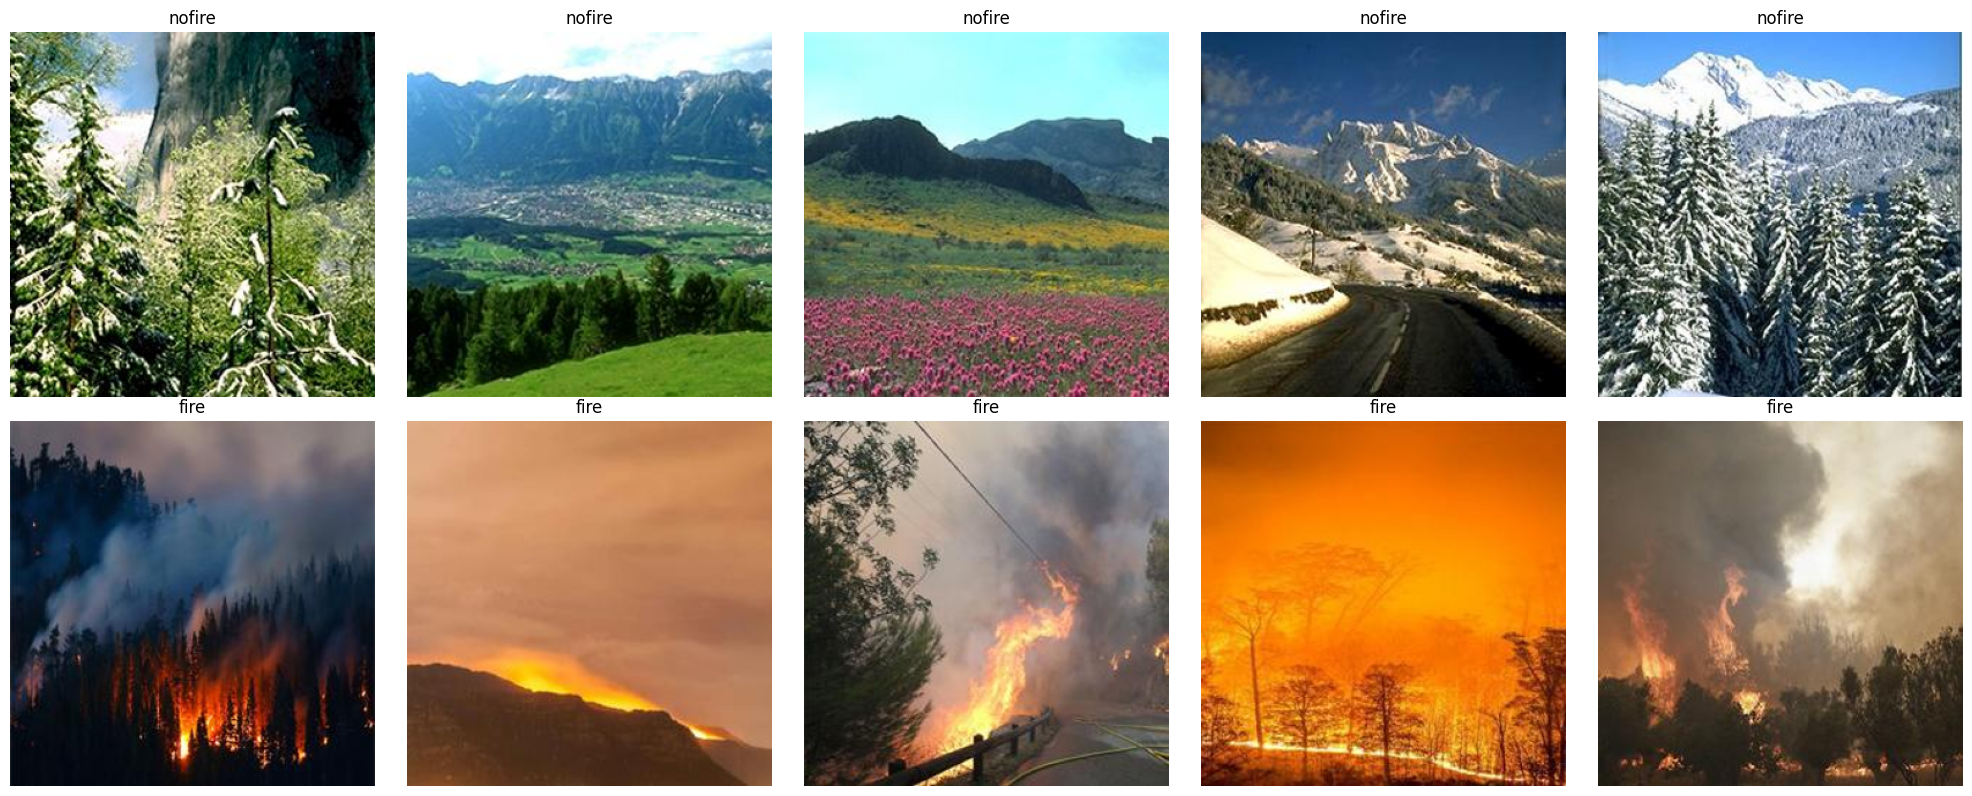

In [13]:

def plot_sample_images(df, samples_per_class=5, image_size=(4,4)):
    labels = df.label.unique()
    n_classes = len(labels)
    fig, axes = plt.subplots(n_classes, samples_per_class,
                             figsize=(samples_per_class*image_size[0], n_classes*image_size[1]))

    for i, label in enumerate(labels):
        sample_paths = df[df.label==label].sample(samples_per_class,
                                                  random_state=CONFIG["RANDOM_SEED"])['filepath'].values
        for j, img_path in enumerate(sample_paths):
            ax = axes[i, j] if n_classes>1 else axes[j]
            img = Image.open(img_path).resize((CONFIG["IMAGE_SIZE"][0], CONFIG["IMAGE_SIZE"][1]))
            ax.imshow(img)
            ax.set_title(label)
            ax.axis('off')

    plt.tight_layout()
    plt.show()


print("Visualizando amostras do dataset:")
plot_sample_images(df, samples_per_class=5)


# 3. Pipelines com tf.data + data augmentation

In [8]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, CONFIG["IMAGE_SIZE"])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_dataset(df, shuffle=False, augment=False):
    paths  = df.filepath.values
    labels = pd.get_dummies(df.label).values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(2048, seed=CONFIG["RANDOM_SEED"])
    if augment:
        ds = ds.map(lambda x,y: (tf.image.random_flip_left_right(x), y),
                    num_parallel_calls=AUTOTUNE)

    return ds.batch(CONFIG["BATCH_SIZE"]).prefetch(AUTOTUNE)

train_ds = make_dataset(train, shuffle=True, augment=True)
val_ds   = make_dataset(val)
test_ds  = make_dataset(test)
print(train_ds.element_spec)


(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.bool, name=None))


# 4. Função de construção de modelo raw / TL / fine-tuning

In [33]:
# Modelos
from tensorflow.keras import layers, models, applications

def build_raw_model(input_shape=(299,299,3), n_classes=2, lr=1e-4):
    model = models.Sequential([
        layers.Input(input_shape),
        layers.Conv2D(32,3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64,3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(n_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def build_tl_model(input_shape=(299,299,3), n_classes=2, lr=1e-4):
    base = applications.InceptionV3(
        input_shape=input_shape, include_top=False, weights="imagenet"
    )
    base.trainable = False
    x = layers.Flatten()(base.output)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    model = models.Model(base.input, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def unfreeze_and_compile(model, base_model, fine_layers=10, lr=1e-6):
    total = len(base_model.layers)
    for l in base_model.layers[: total - fine_layers]:
        l.trainable = False
    for l in base_model.layers[ total - fine_layers :]:
        l.trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# 5. Treinamento dos modelos

In [34]:
# Treinamento e após salvar o modelo
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def get_callbacks(name):
    # Corrected variable name from MODELS_PATH to MODELS_PATH_obj
    filepath = MODELS_PATH_obj / f"{name}_{{epoch:02d}}_{{val_accuracy:.4f}}.h5"
    return [
        EarlyStopping("val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau("val_loss", factor=0.5, patience=3),
        ModelCheckpoint(str(filepath), "val_accuracy", save_best_only=True)
    ]

In [11]:
# Raw model
raw = build_raw_model(n_classes=len(df.label.unique()), lr=CONFIG["LR_RAW"])
history_raw = raw.fit(
    train_ds, validation_data=val_ds,

    epochs=CONFIG["EPOCHS_RAW"],
    callbacks=get_callbacks("raw_model")
)
print("Raw model melhor val_accuracy:", max(history_raw.history["val_accuracy"]))




Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8056 - loss: 0.5887

46/46 ━━━━━━━━━━━━━━━━━━━━ 281s 6s/step - accuracy: 0.8072 - loss: 0.5840 - val_accuracy: 0.8992 - val_loss: 0.3042 - learning_rate: 1.0000e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9404 - loss: 0.1794

46/46 ━━━━━━━━━━━━━━━━━━━━ 322s 6s/step - accuracy: 0.9405 - loss: 0.1789 - val_accuracy: 0.9428 - val_loss: 0.1857 - learning_rate: 1.0000e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.9380 - loss: 0.1672 - val_accuracy: 0.9373 - val_loss: 0.1895 - learning_rate: 1.0000e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9359 - loss: 0.1511

46/46 ━━━━━━━━━━━━━━━━━━━━ 328s 6s/step - accuracy: 0.9362 - loss: 0.1504 - val_accuracy: 0.9482 - val_loss: 0.1711 - learning_rate: 1.0000e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 315s 6s/step - accuracy: 0.9716 - loss: 0.0795 - val_accuracy: 0.9482 - val_loss: 0.1361 - learning_rate: 1.0000e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 321s 6s/step - accuracy: 0.9767 - loss: 0.0744 - val_accuracy: 0.9482 - val_loss: 0.1910 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9771 - loss: 0.0655

46/46 ━━━━━━━━━━━━━━━━━━━━ 325s 6s/step - accuracy: 0.9772 - loss: 0.0655 - val_accuracy: 0.9510 - val_loss: 0.1287 - learning_rate: 1.0000e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9874 - loss: 0.0508

46/46 ━━━━━━━━━━━━━━━━━━━━ 330s 6s/step - accuracy: 0.9874 - loss: 0.0509 - val_accuracy: 0.9564 - val_loss: 0.1166 - learning_rate: 1.0000e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 310s 6s/step - accuracy: 0.9877 - loss: 0.0517 - val_accuracy: 0.9537 - val_loss: 0.1474 - learning_rate: 1.0000e-04
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9869 - loss: 0.0481

46/46 ━━━━━━━━━━━━━━━━━━━━ 332s 6s/step - accuracy: 0.9869 - loss: 0.0480 - val_accuracy: 0.9591 - val_loss: 0.1439 - learning_rate: 1.0000e-04
Raw model melhor val_accuracy: 0.9591280817985535


In [12]:
# Transfer Learning
tl = build_tl_model(n_classes=len(df.label.unique()), lr=CONFIG["LR_TL"])
history_tl = tl.fit(
    train_ds, validation_data=val_ds,
    epochs=CONFIG["EPOCHS_TL"],
    callbacks=get_callbacks("tl_model")
)
print("TL model melhor val_accuracy:", max(history_tl.history["val_accuracy"]))



Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8454 - loss: 1.0191 

46/46 ━━━━━━━━━━━━━━━━━━━━ 690s 15s/step - accuracy: 0.8472 - loss: 1.0075 - val_accuracy: 0.9809 - val_loss: 0.3241 - learning_rate: 1.0000e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 643s 14s/step - accuracy: 0.9879 - loss: 0.1034 - val_accuracy: 0.9728 - val_loss: 0.2108 - learning_rate: 1.0000e-04
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 597s 13s/step - accuracy: 0.9857 - loss: 0.1073 - val_accuracy: 0.9809 - val_loss: 0.1794 - learning_rate: 1.0000e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 663s 14s/step - accuracy: 0.9929 - loss: 0.0555 - val_accuracy: 0.9755 - val_loss: 0.2522 - learning_rate: 1.0000e-04
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 633s 13s/step - accuracy: 0.9838 - loss: 0.1464 - val_accuracy: 0.9673 - val_loss: 0.3316 - learning_rate: 1.0000e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 663s 14s/step - accuracy: 0.9946 - loss: 0.0338 - val_accuracy: 0.9782 - val_loss: 0.2396 - learning_rate: 1.0000e-04
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9964 - loss

46/46 ━━━━━━━━━━━━━━━━━━━━ 663s 14s/step - accuracy: 0.9963 - loss: 0.0188 - val_accuracy: 0.9837 - val_loss: 0.1833 - learning_rate: 5.0000e-05
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 652s 14s/step - accuracy: 0.9945 - loss: 0.0152 - val_accuracy: 0.9809 - val_loss: 0.2058 - learning_rate: 5.0000e-05
TL model melhor val_accuracy: 0.9836512207984924


# 6. Avaliação e relatório final

=== Raw Model ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91        22
           1       0.98      0.93      0.96        46

    accuracy                           0.94        68
   macro avg       0.93      0.94      0.93        68
weighted avg       0.94      0.94      0.94        68



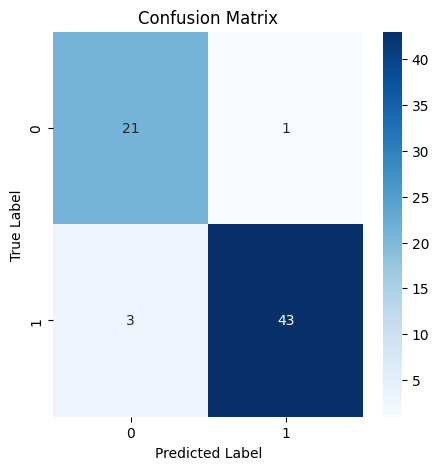

=== TL Model ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        46

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



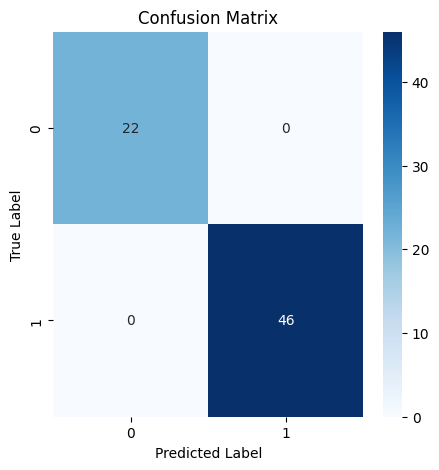

In [21]:
# Avaliação final


def evaluate(model, ds):
    y_true, y_pred = [], []
    for x, y in ds:

        y_true.extend(np.argmax(y.numpy(), axis=1))


        preds = model.predict(x)
        y_pred.extend(np.argmax(preds, axis=1))


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("Classification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Avaliando os modelos
print("=== Raw Model ===")
evaluate(raw, test_ds) # Avalia o modelo raw

print("=== TL Model ===")
evaluate(tl, test_ds) # Avalia o modelo tl




# Importar modelos salvos no drive

In [37]:
# Montar o drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [38]:
# Importe as bibliotecas e CONFIG
import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf

In [39]:
# Reconstrua o DataFrame e o split
data_dir = Path(CONFIG["EXTRACT_PATH"]) / "forest_fire"
records = []
for subset in data_dir.iterdir():
    if subset.is_dir():
        for label in subset.iterdir():
            for img in label.rglob("*.[jp][pn]g"):
                records.append({
                    "filepath": str(img),
                    "label":    label.name,
                    "subset":   subset.name
                })
df = pd.DataFrame(records)

In [40]:
# Separar teste e test_ds novamente
test_df = df[df.subset == "Testing"]

def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, CONFIG["IMAGE_SIZE"])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_dataset(df, shuffle=False, augment=False):
    paths  = df.filepath.values
    labels = pd.get_dummies(df.label).values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(2048, seed=CONFIG["RANDOM_SEED"])
    if augment:
        ds = ds.map(lambda x,y: (tf.image.random_flip_left_right(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(CONFIG["BATCH_SIZE"]).prefetch(tf.data.AUTOTUNE)

test_ds = make_dataset(test_df)

In [41]:
# Eecarregar e compilar os dados
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

RAW_MODEL_PATH = "/content/drive/MyDrive/raw_model_0.9591.h5"
TL_MODEL_PATH  = "/content/drive/MyDrive/tl_model_0.9837.h5"

raw = load_model(RAW_MODEL_PATH)
tl  = load_model(TL_MODEL_PATH)

raw.compile(
    optimizer=Adam(CONFIG["LR_RAW"]),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
tl.compile(
    optimizer=Adam(CONFIG["LR_TL"]),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


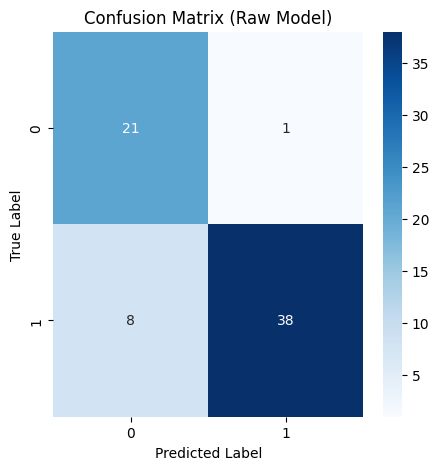

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


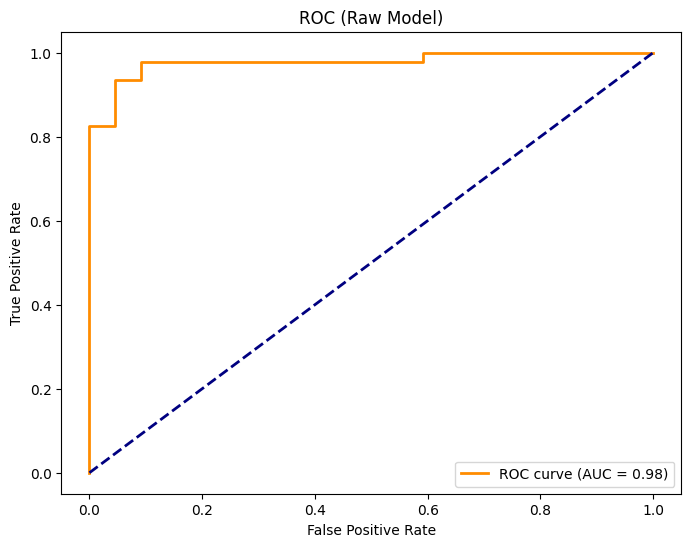

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


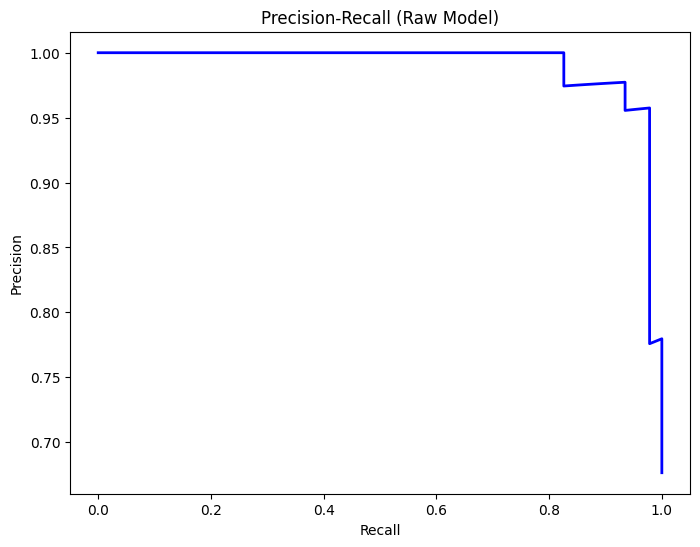

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


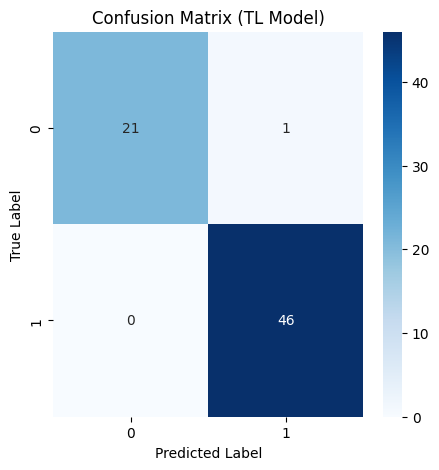

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


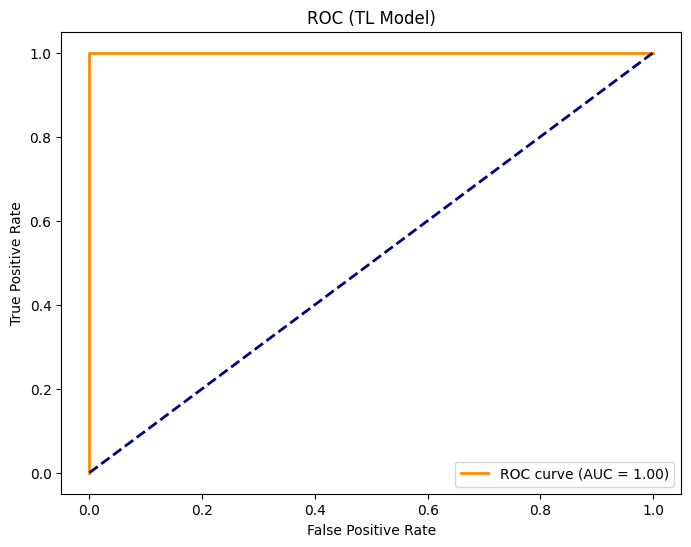

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


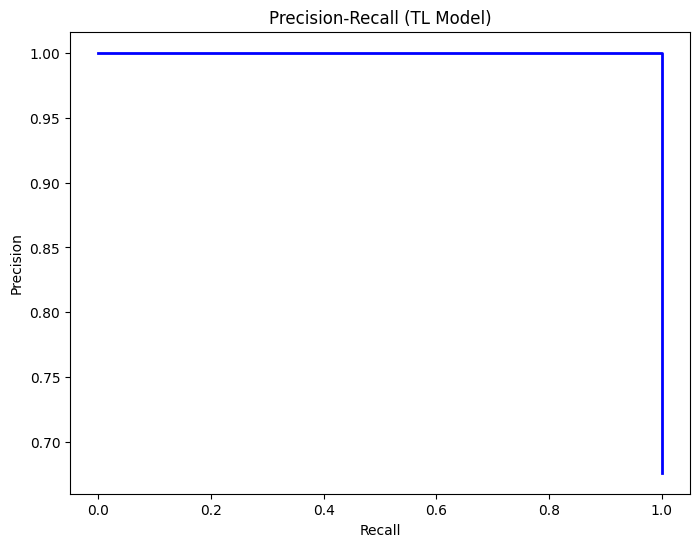

In [36]:
# Funções de plotagem:
plot_confusion_matrix(raw,   test_ds, "Raw Model")
plot_roc_curve(raw,          test_ds, "Raw Model")
plot_precision_recall_curve(raw, test_ds, "Raw Model")

plot_confusion_matrix(tl,    test_ds, "TL Model")
plot_roc_curve(tl,           test_ds, "TL Model")
plot_precision_recall_curve(tl,  test_ds, "TL Model")
